In [1]:
import nglui
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in the soma table to get IDs of cells with cell bodies in volume
soma_df = pd.read_csv('../soma_valence_v185.csv')

In [3]:
soma_df.head()

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm,found
0,17,e,[103860 44385 891],648518346349540057,415440,415440,4154400,1
1,453,e,[84054 50604 1424],648518346349538466,336216,336216,3362160,1
2,35,e,[103728 54333 304],648518346349538711,414912,414912,4149120,1
3,74,e,[51543 57568 155],648518346349538715,206172,206172,2061720,1
4,231,e,[77197 61773 428],648518346349537038,308788,308788,3087880,1


In [4]:
# read in the synapse table 
syn_df = pd.read_csv('../pni_synapses_v185.csv')

In [5]:
# 3.2 million rows
print(syn_df.shape)

(3239275, 16)


In [6]:
syn_df.head()

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335


In [7]:
# filter for neuron somas
neuron_df=soma_df.query('cell_type == "i" | cell_type=="e"')

In [8]:
# filter synapses onto neurons
post_neuron_syn_df=syn_df[syn_df.post_root_id.isin(neuron_df.pt_root_id)]

In [9]:
# 951,457 of 3.5 million synapses are only 
post_neuron_syn_df.shape

(951457, 16)

In [10]:
# Lets summarize the number of inputs these cells have
in_degree_df = post_neuron_syn_df.groupby('post_root_id').post_root_id.count()


In [11]:
in_degree_df.head()

post_root_id
648518346349477331     494
648518346349487432     434
648518346349487752     783
648518346349488919    2626
648518346349489861    1841
Name: post_root_id, dtype: int64

In [12]:
# find the cell with the most inputs
# here is that neuron's ID
max_input_neuron=in_degree_df.index[in_degree_df.argmax()]
print(max_input_neuron)

648518346349538440


In [13]:
# it has 5369 input synapses
in_degree_df[max_input_neuron]

5369

In [14]:
# lets filter those synapses
onto_cell_syn_df = post_neuron_syn_df.query(f'post_root_id == {max_input_neuron}')

In [15]:
from nglui.statebuilder import *
# get sources from the neuroglancer link
img_source = "precomputed://gs://neuroglancer/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://gs://microns_public_datasets/pinky100_v185/seg"

# use nglui (www.github.com/seung-lab/NeuroglancerAnnotationUI) to setup a dataframe > neuroglancer link pipeline
img_layer = ImageLayerConfig(name='layer23',
                             source=img_source,
                             )
# we want the segmentation layer with our target neuron always on
seg_layer = SegmentationLayerConfig(name = 'seg',
                                    source = seg_source,
                                    fixed_ids=[max_input_neuron])

# need to consolidate the synapse position into a single column
onto_cell_syn_df.loc[:, 'ctr_pos']=onto_cell_syn_df.apply(lambda x: [x.ctr_pos_x_vx, x.ctr_pos_y_vx, x.ctr_pos_z_vx], axis=1).copy()

# setup a mapping rule for point annotations
syn_points = PointMapper(point_column='ctr_pos', linked_segmentation_column='pre_root_id')
# add these points linked to the segmentation layer name
syn_layer = AnnotationLayerConfig(name='synapses', mapping_rules=syn_points, linked_segmentation_layer='seg')


/opt/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
# setup a state builder with this layer pipeline
sb = StateBuilder([img_layer, seg_layer, syn_layer])

# render the state pipeline with the dataframe data
# returning the link as an html link
sb.render_state(onto_cell_syn_df, return_as='html')

In [17]:
# Lets repeat the exercise to find cells with the most outputs
pre_neuron_syn_df = syn_df[syn_df.pre_root_id.isin(neuron_df.pt_root_id)]
out_degree_df = pre_neuron_syn_df.groupby('pre_root_id').post_root_id.count()


In [18]:
# in contrast to inputs only 15,884 outputs of the
# 3.2 million synapses can be connected
# to cells with cell bodies in volume
pre_neuron_syn_df.shape

(15884, 16)

In [19]:
# since we have the data, lets make a dataframe with all the cells in degree
# and out degree
in_out_df = pd.DataFrame({'in_degree': in_degree_df, 'out_degree':out_degree_df})

In [20]:
# merge in the cell type information we have on these cells
in_out_ct_df = pd.merge(in_out_df, soma_df[['cell_type','pt_root_id']], left_index=True, right_on='pt_root_id' )

/opt/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


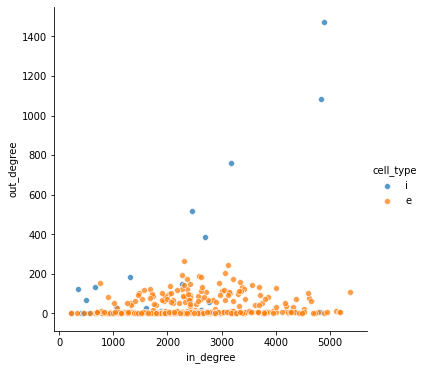

In [21]:
# you can see here that many cells have low out-degree 
# as excitatory neurons in the bottom half of the dataset
# have axons which leave the bottom of the volume
# before branching, bu there are 5 inhibitory neurons with >300 synapses

# the in degree varies from a few hundred to >5000 depending on how much
# dendrite is in the volume

#f, ax = plt.subplots(figsize=(8,8))
sns.pairplot(x_vars=['in_degree'], y_vars=['out_degree'],
             data=in_out_ct_df, hue='cell_type', plot_kws={'alpha': 0.75},  size=5)


In [22]:
in_out_ct_df.query('out_degree>300')

,in_degree,out_degree,cell_type,pt_root_id
319,4831,1082.0,i,648518346349528994
315,2459,516.0,i,648518346349538179
175,2698,386.0,i,648518346349538791
340,4891,1475.0,i,648518346349539215
185,3172,761.0,i,648518346349539846


In [23]:
# let's get all these synapses from these neurons
is_from_most_out = pre_neuron_syn_df.pre_root_id.isin(in_out_ct_df.query('out_degree>300').pt_root_id.values)
most_inh_syn_out = pre_neuron_syn_df[is_from_most_out]

In [24]:
# here are our 4220 synapses
most_inh_syn_out.shape

(4220, 16)

In [25]:
# lets visualize them all in neuroglancer
most_inh_syn_out.loc[:, 'ctr_pos']=most_inh_syn_out.apply(lambda x: [x.ctr_pos_x_vx, x.ctr_pos_y_vx, x.ctr_pos_z_vx], axis=1).copy()

seg_layer = SegmentationLayerConfig(name = 'seg',
                                    source = seg_source,
                                    selected_ids_column='pre_root_id')

# setup a mapping rule for point annotations
syn_points = PointMapper(point_column='ctr_pos', linked_segmentation_column='post_root_id')
# add these points linked to the segmentation layer name
syn_layer = AnnotationLayerConfig(name='synapses', mapping_rules=syn_points, linked_segmentation_layer='seg')

sb = StateBuilder([img_layer, seg_layer, syn_layer])
# returning the link as an html link
sb.render_state(most_inh_syn_out, return_as='html')

/opt/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
# maybe that's a bit overwhelming... lets cut the dataframe to just the cell with the most
# outputs, it's a basket cell, check out how many times it makes multiple synapses 
# with the same target, you can quickly get a sense for how it distributes its 
# outputs across different post-synaptic target structures.
sb.render_state(most_inh_syn_out.query('pre_root_id == 648518346349539215'), return_as='html')